In [18]:
# ライブラリの導入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Noto Sans CJK JP"  # 日本語入力対応

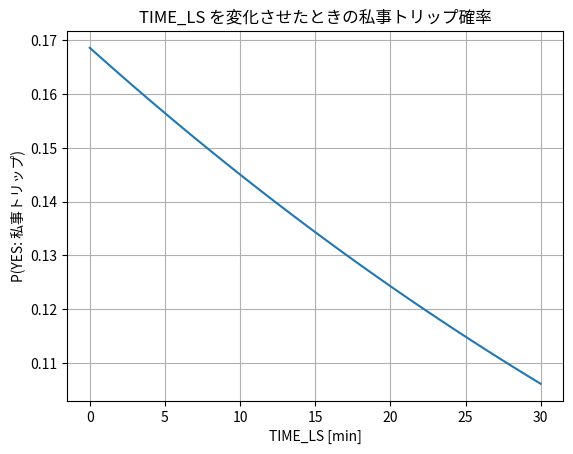

In [19]:
# ---------- 推定されたパラメータ ----------
# 下位（ログサム用）
B_TIME_LS   = -0.287723
ASC_BICYCLE = -4.378480
ASC_BUS     = -2.091492
ASC_CAR     = -6.213878

# 上位（YES/NO）
ASC_YES      = 4.438569
B_MACMTIME   = -0.537040
B_WORKTIME   = -0.491576
B_HHM_all    = -0.241752
B_N_EKI_SCORE = 0.016789
B_LOGSUM     = 0.062106

# ---------- 上位モデルのその他の説明変数（ここは好きな値に固定してください） ----------
# 例として、「代表的な一人」の値を固定
MACMTIME   = 55.917761/60   # 平均値[時間]
WORKTIME   = 604.826367/60  # 平均値[時間]
HHM_all    = 2    # 世帯人数2人
N_EKI_SCORE = 1684314.03018102 / 1000000   # 阿佐ヶ谷の値

# 端末時間の変動範囲
time_range = np.linspace(0, 30, 61) # 0.5分ずつ

# 結果格納用
P_yes_list = []
LS_list = []

for t in time_range:
    # ----- 下位モデル：モード別効用 -----
    # ここでは簡単のため、3モードすべての時間が同じ t 分だと仮定しています
    # 実際には mode ごとに時間が違うなら、BICYCLE_TIME(t), BUS_TIME(t), CAR_TIME(t) などに変更してください
    V_bicycle = ASC_BICYCLE + B_TIME_LS * t
    V_bus     = ASC_BUS     + B_TIME_LS * t
    V_car     = ASC_CAR     + B_TIME_LS * t

    # ログサム（inclusive value）
    sum_exp = np.exp(V_bicycle) + np.exp(V_bus) + np.exp(V_car)
    LS = np.log(sum_exp)
    LS_list.append(LS)

    # ----- 上位モデル：YES の効用 -----
    V_yes = (
        ASC_YES
        + B_MACMTIME   * MACMTIME
        + B_WORKTIME   * WORKTIME
        + B_HHM_all    * HHM_all
        + B_N_EKI_SCORE * N_EKI_SCORE
        + B_LOGSUM     * LS
    )

    # 二項ロジットの確率
    P_yes = np.exp(V_yes) / (1.0 + np.exp(V_yes))
    P_yes_list.append(P_yes)

P_yes_arr = np.array(P_yes_list)
LS_arr = np.array(LS_list)

# 私事トリップをする確率 – TIME_LS の関係
plt.figure()
plt.plot(time_range, P_yes_arr)
plt.xlabel("TIME_LS [min]")   # ここは実際の単位に合わせて変更
plt.ylabel("P(YES: 私事トリップ)")
plt.title("TIME_LS を変化させたときの私事トリップ確率")
plt.grid(True)
plt.show()


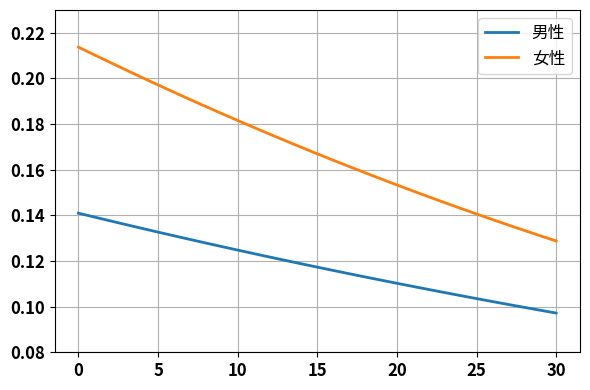

In [29]:
# 端末時間の可視化
# =========================
# 1. 係数（男女別）
# =========================
coef_male = {
    # 下位（ログサム）
    "B_TIME_LS":   -0.282907,
    "ASC_BICYCLE": -4.520451,
    "ASC_BUS":     -2.245349,
    "ASC_CAR":     -6.398523,
    # 上位（YES/NO）
    "ASC_YES":       4.088910,
    "B_MACMTIME":   -0.483500,
    "B_WORKTIME":   -0.492077,
    "B_HHM_all":    -0.204196,
    "B_N_EKI_SCORE": 0.017205,
    "B_LOGSUM":      0.049658,
}

coef_female = {
    # 下位（ログサム）
    "B_TIME_LS":   -0.316268,
    "ASC_BICYCLE": -4.240733,
    "ASC_BUS":     -1.798419,
    "ASC_CAR":     -5.997479,
    # 上位（YES/NO）
    "ASC_YES":       4.229357,
    "B_MACMTIME":   -0.431006,
    "B_WORKTIME":   -0.455349,
    "B_HHM_all":    -0.229091,
    "B_N_EKI_SCORE": 0.016143,
    "B_LOGSUM":      0.064203,
}

# =========================
# 2. 上位モデルのその他の説明変数
#    （推定時と同じスケーリングに注意）
# =========================
MACMTIME_mean = 55.917761 / 60   # 例：平均通勤時間[時間]
WORKTIME_mean = 604.826367 / 60  # 例：平均就業時間[時間]
HHM_all_mean  = 2                # 例：世帯人数2人

# ★土地利用指標は推定時と同じスケールを使う（必要なら /1e6 など）
N_EKI_SCORE_val = 1684314.03018102 / 1e6   # 例：阿佐ヶ谷、/1e6 して使った想定

macro_male = {
    "MACMTIME":   MACMTIME_mean,
    "WORKTIME":   WORKTIME_mean,
    "HHM_all":    HHM_all_mean,
    "N_EKI_SCORE": N_EKI_SCORE_val,
}

macro_female = macro_male.copy()   # 男女で同じ代表値を使う場合


# =========================
# 3. P(YES) を計算する関数
# =========================
def calc_p_yes(time_range, coef, macro):
    P_yes_list = []
    LS_list = []

    for t in time_range:
        # ---- 下位モデル：モード別効用 ----
        V_bic = coef["ASC_BICYCLE"] + coef["B_TIME_LS"] * t
        V_bus = coef["ASC_BUS"]     + coef["B_TIME_LS"] * t
        V_car = coef["ASC_CAR"]     + coef["B_TIME_LS"] * t

        sum_exp = np.exp(V_bic) + np.exp(V_bus) + np.exp(V_car)
        LS = np.log(sum_exp)
        LS_list.append(LS)

        # ---- 上位モデル：YES の効用 ----
        V_yes = (
            coef["ASC_YES"]
            + coef["B_MACMTIME"]   * macro["MACMTIME"]
            + coef["B_WORKTIME"]   * macro["WORKTIME"]
            + coef["B_HHM_all"]    * macro["HHM_all"]
            + coef["B_N_EKI_SCORE"]* macro["N_EKI_SCORE"]
            + coef["B_LOGSUM"]     * LS
        )

        # 数値的に安定なロジット式
        P_yes = 1.0 / (1.0 + np.exp(-V_yes))
        P_yes_list.append(P_yes)

    return np.array(P_yes_list), np.array(LS_list)


# =========================
# 4. TIME_LS を 0〜30分動かして男女の曲線を計算
# =========================
time_range = np.linspace(0, 30, 61)  # 0,0.5,...,30 [min]

P_yes_male,   LS_male   = calc_p_yes(time_range, coef_male,   macro_male)
P_yes_female, LS_female = calc_p_yes(time_range, coef_female, macro_female)

# =========================
# 5. プロット（男女を同じ図に）
# =========================
plt.figure(figsize=(6,4))
plt.plot(time_range, P_yes_male,   label="男性", linewidth=2)
plt.plot(time_range, P_yes_female, label="女性", linewidth=2)

plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")

plt.ylim(0.08, 0.23) # 縦軸のminとMax　メイン時間と合わせる

#plt.xlabel("TIME_LS [min]")
#plt.ylabel("P(YES: 私事トリップ)")
#plt.title("TIME_LS を変化させたときの私事トリップ確率（男女比較）")
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [21]:
# 実際のポイント差を算出
# 関数がリストを渡す前提で作成されているため，1列のリストを渡す必要がある
times = [5, 15]
P_yes_male, LS_male = calc_p_yes(times, coef_male, macro_male)
P_yes_female, LS_female = calc_p_yes(times, coef_female, macro_female)
print("男性の端末5分の場合の確率", P_yes_male[0])
print("男性の端末15分の場合の確率", P_yes_male[1])
print("女性の端末5分の場合の確率", P_yes_female[0])
print("女性の端末15分の場合の確率", P_yes_female[1])

男性の端末5分の場合の確率 0.1326600574735021
男性の端末15分の場合の確率 0.11731279669809014
女性の端末5分の場合の確率 0.19715185886557898
女性の端末15分の場合の確率 0.16697148322038782


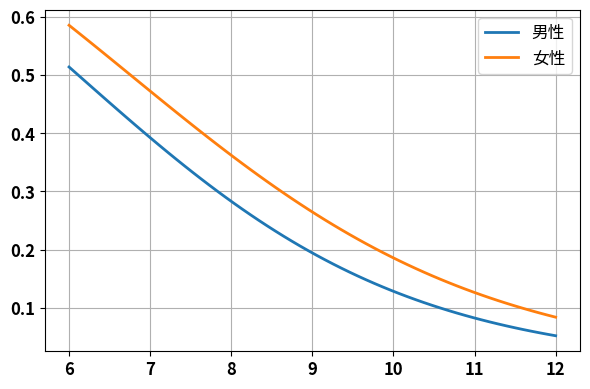

In [30]:
# 就業時間の感度を可視化
# =========================
# 1. 係数（男女別）
# =========================
coef_male = {
    # 下位（ログサム）
    "B_TIME_LS":   -0.282907,
    "ASC_BICYCLE": -4.520451,
    "ASC_BUS":     -2.245349,
    "ASC_CAR":     -6.398523,
    # 上位（YES/NO）
    "ASC_YES":       4.088910,
    "B_MACMTIME":   -0.483500,
    "B_WORKTIME":   -0.492077,
    "B_HHM_all":    -0.204196,
    "B_N_EKI_SCORE": 0.017205,
    "B_LOGSUM":      0.049658,
}

coef_female = {
    # 下位（ログサム）
    "B_TIME_LS":   -0.316268,
    "ASC_BICYCLE": -4.240733,
    "ASC_BUS":     -1.798419,
    "ASC_CAR":     -5.997479,
    # 上位（YES/NO）
    "ASC_YES":       4.229357,
    "B_MACMTIME":   -0.431006,
    "B_WORKTIME":   -0.455349,
    "B_HHM_all":    -0.229091,
    "B_N_EKI_SCORE": 0.016143,
    "B_LOGSUM":      0.064203,
}

# =========================
# 2. 上位モデルのその他の説明変数
# =========================
MACMTIME_mean = 55.917761 / 60   # 例：平均通勤時間[時間]
#WORKTIME_mean = 604.826367 / 60  # 例：平均就業時間[時間]
HHM_all_mean  = 2                # 例：世帯人数2人
TIME_LS_mean = 10.387202 # 平均値[分]

# ★土地利用指標は推定時と同じスケールを使う（必要なら /1e6 など）
N_EKI_SCORE_val = 1684314.03018102 / 1e6   # 例：阿佐ヶ谷、/1e6 して使った想定

macro_male = {
    "MACMTIME":   MACMTIME_mean,
    "WORKTIME":   WORKTIME_mean,
    "HHM_all":    HHM_all_mean,
    "N_EKI_SCORE": N_EKI_SCORE_val,
}

macro_female = macro_male.copy()   # 男女で同じ代表値を使う場合


# =========================
# 3. P(YES) を計算する関数
# =========================
def calc_p_yes_worktime(worktime_range, coef, macro, time_ls_fixed):
    P_yes_list = []
    LS_list = []

    for w in worktime_range:
        # ---- 下位モデル：モード別効用（TIME_LS は固定値）----
        V_bic = coef["ASC_BICYCLE"] + coef["B_TIME_LS"] * time_ls_fixed
        V_bus = coef["ASC_BUS"]     + coef["B_TIME_LS"] * time_ls_fixed
        V_car = coef["ASC_CAR"]     + coef["B_TIME_LS"] * time_ls_fixed

        sum_exp = np.exp(V_bic) + np.exp(V_bus) + np.exp(V_car)
        LS = np.log(sum_exp)
        LS_list.append(LS)

        # ---- 上位モデル：YES の効用（WORKTIME だけ w で変える）----
        V_yes = (
            coef["ASC_YES"]
            + coef["B_MACMTIME"]   * macro["MACMTIME"]
            + coef["B_WORKTIME"]   * w               # ★ここが変動
            + coef["B_HHM_all"]    * macro["HHM_all"]
            + coef["B_N_EKI_SCORE"]* macro["N_EKI_SCORE"]
            + coef["B_LOGSUM"]     * LS
        )

        # 数値的に安定なロジット式
        P_yes = 1.0 / (1.0 + np.exp(-V_yes))
        P_yes_list.append(P_yes)

    return np.array(P_yes_list), np.array(LS_list)


# =========================
# 4. WORKTIME を 6〜12時間で動かして男女の曲線を計算
# =========================
worktime_range = np.linspace(6, 12, 60)  # 10分ごと

P_yes_male_w,  LS_male_w  = calc_p_yes_worktime(
    worktime_range, coef_male, macro_male, TIME_LS_mean
)
P_yes_fem_w,   LS_fem_w   = calc_p_yes_worktime(
    worktime_range, coef_female, macro_female, TIME_LS_mean
)

# =========================
# 5. プロット（男女を同じ図に）
# =========================
plt.figure(figsize=(6,4))
plt.plot(worktime_range, P_yes_male_w,  label="男性", linewidth=2)
plt.plot(worktime_range, P_yes_fem_w,   label="女性", linewidth=2)

plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")

#plt.xlabel("WORKTIME [hour]")
#plt.ylabel("P(YES: 私事トリップ)")
#plt.title("WORKTIME を変化させたときの私事トリップ確率（男女比較）")
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

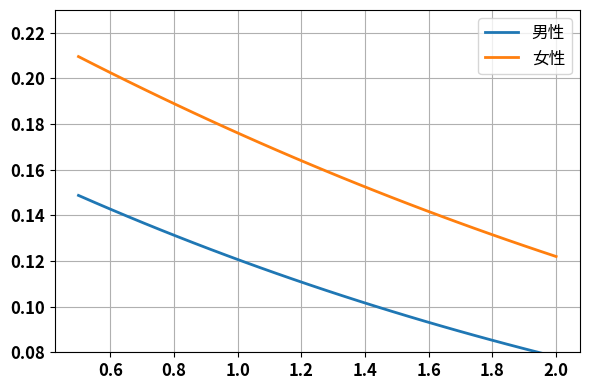

In [31]:
# 就業時間の感度を可視化
# =========================
# 1. 係数（男女別）
# =========================
coef_male = {
    # 下位（ログサム）
    "B_TIME_LS":   -0.282907,
    "ASC_BICYCLE": -4.520451,
    "ASC_BUS":     -2.245349,
    "ASC_CAR":     -6.398523,
    # 上位（YES/NO）
    "ASC_YES":       4.088910,
    "B_MACMTIME":   -0.483500,
    "B_WORKTIME":   -0.492077,
    "B_HHM_all":    -0.204196,
    "B_N_EKI_SCORE": 0.017205,
    "B_LOGSUM":      0.049658,
}

coef_female = {
    # 下位（ログサム）
    "B_TIME_LS":   -0.316268,
    "ASC_BICYCLE": -4.240733,
    "ASC_BUS":     -1.798419,
    "ASC_CAR":     -5.997479,
    # 上位（YES/NO）
    "ASC_YES":       4.229357,
    "B_MACMTIME":   -0.431006,
    "B_WORKTIME":   -0.455349,
    "B_HHM_all":    -0.229091,
    "B_N_EKI_SCORE": 0.016143,
    "B_LOGSUM":      0.064203,
}

# =========================
# 2. 上位モデルのその他の説明変数
# =========================
#MACMTIME_mean = 55.917761 / 60   # 例：平均通勤時間[時間]
WORKTIME_mean = 604.826367 / 60  # 例：平均就業時間[時間]
HHM_all_mean  = 2                # 例：世帯人数2人
TIME_LS_mean = 10.387202 # 平均値[分]

# ★土地利用指標は推定時と同じスケールを使う（必要なら /1e6 など）
N_EKI_SCORE_val = 1684314.03018102 / 1e6   # 例：阿佐ヶ谷、/1e6 して使った想定

macro_male = {
    "MACMTIME":   MACMTIME_mean,
    "WORKTIME":   WORKTIME_mean,
    "HHM_all":    HHM_all_mean,
    "N_EKI_SCORE": N_EKI_SCORE_val,
}

macro_female = macro_male.copy()   # 男女で同じ代表値を使う場合


# =========================
# 3. P(YES) を計算する関数
# =========================
def calc_p_yes_MACMtime(MACMtime_range, coef, macro, time_ls_fixed):
    P_yes_list = []
    LS_list = []

    for w in MACMtime_range:
        # ---- 下位モデル：モード別効用（TIME_LS は固定値）----
        V_bic = coef["ASC_BICYCLE"] + coef["B_TIME_LS"] * time_ls_fixed
        V_bus = coef["ASC_BUS"]     + coef["B_TIME_LS"] * time_ls_fixed
        V_car = coef["ASC_CAR"]     + coef["B_TIME_LS"] * time_ls_fixed

        sum_exp = np.exp(V_bic) + np.exp(V_bus) + np.exp(V_car)
        LS = np.log(sum_exp)
        LS_list.append(LS)

        # ---- 上位モデル：YES の効用（WORKTIME だけ w で変える）----
        V_yes = (
            coef["ASC_YES"]
            + coef["B_MACMTIME"]   * w # ここが変動
            + coef["B_WORKTIME"]   * macro["WORKTIME"]              
            + coef["B_HHM_all"]    * macro["HHM_all"]
            + coef["B_N_EKI_SCORE"]* macro["N_EKI_SCORE"]
            + coef["B_LOGSUM"]     * LS
        )

        # 数値的に安定なロジット式
        P_yes = 1.0 / (1.0 + np.exp(-V_yes))
        P_yes_list.append(P_yes)

    return np.array(P_yes_list), np.array(LS_list)


# =========================
# 4. MACM_TIME を 0〜30分動かして男女の曲線を計算
# =========================
MACMtime_range = np.linspace(0.5, 2, 30)  # 5分ごと

P_yes_male_w,  LS_male_w  = calc_p_yes_MACMtime(
    MACMtime_range, coef_male, macro_male, TIME_LS_mean
)
P_yes_fem_w,   LS_fem_w   = calc_p_yes_MACMtime(
    MACMtime_range, coef_female, macro_female, TIME_LS_mean
)

# =========================
# 5. プロット（男女を同じ図に）
# =========================
plt.figure(figsize=(6,4))
plt.plot(MACMtime_range, P_yes_male_w,  label="男性", linewidth=2)
plt.plot(MACMtime_range, P_yes_fem_w,   label="女性", linewidth=2)


plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")

plt.ylim(0.08, 0.23) # 縦軸のminとMax，前のやつと合わせる

#plt.xlabel("MACMTIME [hour]")
#plt.ylabel("P(YES: 私事トリップ)")
#plt.title("MACMTIME を変化させたときの私事トリップ確率（男女比較）")
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [28]:
# 実際のポイント差を算出
# 関数がリストを渡す前提で作成されているため，1列のリストを渡す必要がある
times = [0.5, 1]
P_yes_male_w, LS_male_w = calc_p_yes_MACMtime(times, coef_male, macro_male, TIME_LS_mean)
P_yes_female_w, LS_female_w = calc_p_yes_MACMtime(times, coef_female, macro_female, TIME_LS_mean)
print("男性の通勤メイン30分の場合の確率", P_yes_male_w[0])
print("男性の通勤メイン60分の場合の確率", P_yes_male_w[1])
print("女性の通勤メイン30分の場合の確率", P_yes_female_w[0])
print("女性の通勤メイン60分の場合の確率", P_yes_female_w[1])

男性の通勤メイン30分の場合の確率 0.148746081533061
男性の通勤メイン60分の場合の確率 0.12065736806527513
女性の通勤メイン30分の場合の確率 0.20958945771143658
女性の通勤メイン60分の場合の確率 0.17611339464397519


In [ ]:
# 男女別のモデルの比較
# パラメータ値の入力（fixedは固定値）
# モデル1（man）
asc_m = 
b_macmtime_m =
macmtime_fixed_m = 
b_worktime_m =
worktime_fixed_m = 
b_hhm_m = 
hhm_m = fixed = 
b_eki_m =
eki_fixed_m = 
b_logsum_m =
logsum_fixed_m = 


# logsum部分
asc_bicycle_m =
asc_bus_m =
asc_car_m =
b_time_ls_m = 

# モデル2（female）
asc_f = 
b_macmtime_f =
b_worktime_f =
b_hhm_f = 
b_eki_f =
b_logsum_f =

# logsum部分
asc_bicycle_f =
asc_bus_f =
asc_car_f =
b_time_ls_f =

# モデル3
asc = 
b_macmtime =
b_worktime =
b_hhm = 
b_eki =
b_logsum =

# logsum部分
asc_bicycl =
asc_bus =
asc_car =
b_time_ls =

# ロジスティック関数の定義
def logistic(x):
    return 1 / (1 + np.exp(-x))

# 表示する時間の表示
walk_range = np.linspace(0, 60, 61)

# 効用関数の定義（下位，上位の順番）
V_walk_m =
V_bicycle_m =
V_bus_m =
V_car_m =

V_m = asc_m 

SyntaxError: invalid syntax (3209805174.py, line 4)